# Vanguard S&P 500 ETF Forecast

&emsp;This project builds a **predictive model** for the *Vanguard S&P 500 ETF* stock price.

In [13]:
import random
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
mpl.style.use('seaborn-v0_8-colorblind')
%matplotlib inline

import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import layers

from sklearn.metrics import r2_score

# Seed code
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

# Create Windowed Dataset Function

In [14]:
def create_dataset(orig_dataset, window_size=1):
    data_x, data_y = [], []
    for i in range(len(orig_dataset) - window_size):
        window = orig_dataset.iloc[i:(i + window_size), 0]
        target = orig_dataset.iloc[i + window_size, 0]
        data_x.append(window)
        data_y.append(target)
    return np.array(data_x), np.array(data_y)

# Import Data

In [15]:
# Define the ticker symbol
ticker_symbol = "VOO"

# Create a Ticker object
ticker = yf.Ticker(ticker_symbol)

# Fetch historical market data
voo = ticker.history(period='max')  # data for the last year
print(f"Rows: {voo.shape[0]}\nColumns: {voo.shape[1]}")
voo.head()

Rows: 3626
Columns: 8


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2010-09-09 00:00:00-04:00,78.626523,78.626523,77.583283,77.721359,26500,0.0,0.0,0.0
2010-09-10 00:00:00-04:00,77.997450,78.135526,77.705959,78.074158,8600,0.0,0.0,0.0
2010-09-13 00:00:00-04:00,78.979346,79.117422,78.626486,79.056053,33750,0.0,0.0,0.0
2010-09-14 00:00:00-04:00,78.887312,79.378254,78.534453,79.040733,59400,0.0,0.0,0.0
2010-09-15 00:00:00-04:00,78.718584,79.301566,78.549823,79.240204,9250,0.0,0.0,0.0


In [16]:
voo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3626 entries, 2010-09-09 00:00:00-04:00 to 2025-02-06 00:00:00-05:00
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           3626 non-null   float64
 1   High           3626 non-null   float64
 2   Low            3626 non-null   float64
 3   Close          3626 non-null   float64
 4   Volume         3626 non-null   int64  
 5   Dividends      3626 non-null   float64
 6   Stock Splits   3626 non-null   float64
 7   Capital Gains  3626 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 255.0 KB


* Apparently, there are no missing values.
* For simplicity, `Close` will be used for the analysis and forecasting in the baseline models.

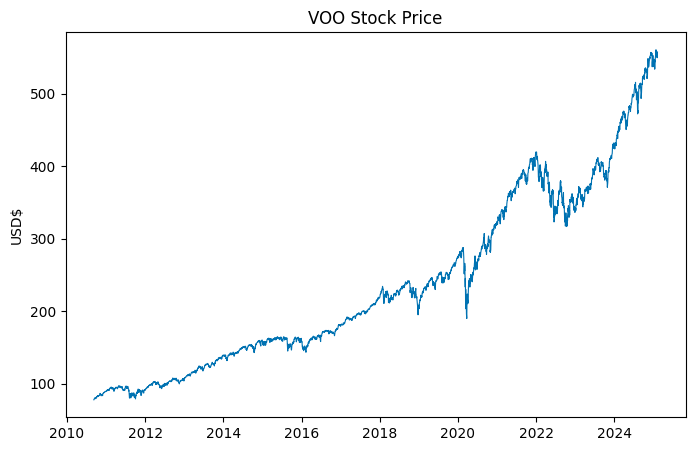

In [17]:
ticks = voo[['Close']]

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(ticks, lw=.8)
ax.set(title="VOO Stock Price", ylabel="USD$")
plt.show()

# Data Preprocessing

## Train Test Split

In [18]:
train = ticks[:int(ticks.shape[0] * .5)]
validate = ticks[int(ticks.shape[0] * .5): int(ticks.shape[0] * .75)]
test = ticks[int(ticks.shape[0] * .75):]
print(f'train: {train.shape}\nvalidate: {validate.shape}\ntest: {test.shape}')

train: (1813, 1)
validate: (906, 1)
test: (907, 1)


## Normalisation

In [19]:
scaler = MinMaxScaler()
scaler.fit(train)
train_scaled = pd.DataFrame(scaler.transform(train), columns=['index'], index=train.index)
validate_scaled = pd.DataFrame(scaler.transform(validate), columns=['index'], index=validate.index)
test_scaled = pd.DataFrame(scaler.transform(test), columns=['index'], index=test.index)

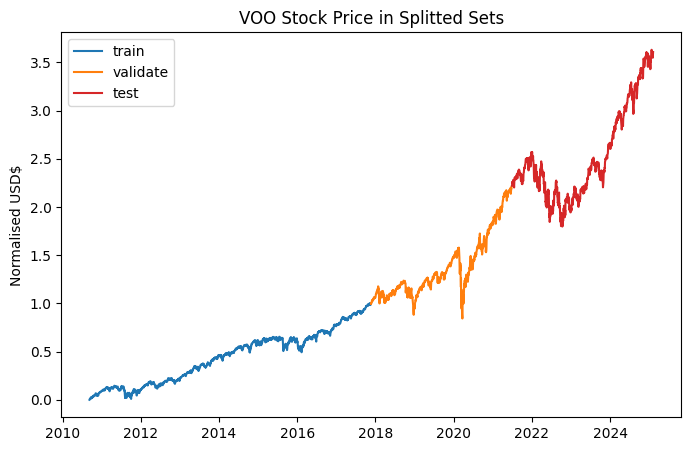

In [20]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(train_scaled, color='tab:blue', label='train')
ax.plot(validate_scaled, color='tab:orange', label='validate')
ax.plot(test_scaled, color='tab:red', label='test')
ax.legend()
plt.title("VOO Stock Price in Splitted Sets")
plt.xlabel("")
plt.ylabel("Normalised USD$")
plt.show()

## Windowed Datasets

In [21]:
window_size = 1
X_train, y_train = create_dataset(train_scaled, window_size=window_size)
X_val, y_val = create_dataset(validate_scaled, window_size=window_size)
X_test, y_test = create_dataset(test_scaled, window_size=window_size)
print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}")
print(f"X_val: {X_val.shape}\ny_val: {y_val.shape}")
print(f"X_test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (1812, 1)
y_train: (1812,)
X_val: (905, 1)
y_val: (905,)
X_test: (906, 1)
y_test: (906,)


## Reshape for modelling

In [22]:
def reshape_df(df):
    return np.reshape(df, (df.shape[0], 1, df.shape[1]))

X_train_reshaped = reshape_df(X_train)
X_val_reshaped = reshape_df(X_val)
X_test_reshaped = reshape_df(X_test)

# Modelling

## Baseline Model - SimpleRNN

/Users/moswai/Documents/Mos_DataScience/tools/venv/venv_DL_tickers/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_7 (SimpleRNN)        │ (None, 10)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241 (964.00 B)

 Trainable params: 241 (964.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 0.4152 
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - loss: 0.0606
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - loss: 0.0172
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 0.0111
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 0.0069
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step


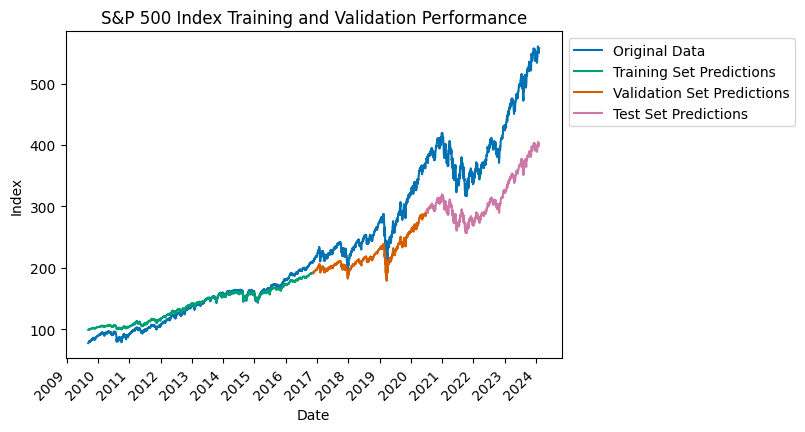

R2 score for training: 0.9329914846600325
R2 score for validation: 0.0685866582196839
R2 score for test: -1.5623826785952821


In [30]:
# Modelling
model = tf.keras.Sequential()

model.add(layers.SimpleRNN(10, input_shape=(1, window_size), activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Fit model with 1 epochs
model.fit(X_train_reshaped, y_train, epochs=5)

# Make predictions on train and validate data
train_pred = model.predict(X_train_reshaped)
val_pred = model.predict(X_val_reshaped)
test_pred = model.predict(X_test_reshaped)

# Un-scale the predictions
train_pred_rescaled = scaler.inverse_transform(train_pred)
val_pred_rescaled = scaler.inverse_transform(val_pred)
test_pred_rescaled = scaler.inverse_transform(test_pred)

# Load in the original data (for comparison)
baseline = ticks
########
def rewindow_train_indexes(window, train_pred):
    return window, len(train_pred) + window

def rewindow_val_indexes(window, train_pred, val_pred):
    return len(train_pred) + 2*window, len(train_pred) + 2*window + len(val_pred)

def rewindow_test_indexes(window, train_pred, val_pred):
    return len(train_pred) + len(val_pred) + 3*window, None

train_start, train_end = rewindow_train_indexes(window_size, train_pred_rescaled)
val_start, val_end = rewindow_val_indexes(window_size, train_pred_rescaled, val_pred_rescaled)
test_start, test_end = rewindow_test_indexes(window_size, train_pred_rescaled, val_pred_rescaled)
########
# Un-window the training predictions
plot_train_pred = np.empty((len(baseline)))
plot_train_pred[:] = np.nan
plot_train_pred[train_start:train_end] = train_pred_rescaled[:,0]
# Un-window the validate predictions
plot_val_pred = np.empty((len(baseline)))
plot_val_pred[:] = np.nan
plot_val_pred[val_start:val_end] = val_pred_rescaled[:,0]
# Un-window the test predictions
plot_test_pred = np.empty((len(baseline)))
plot_test_pred[:] = np.nan
plot_test_pred[test_start:test_end] = test_pred_rescaled[:,0]
# Plot the original data
plt.plot(baseline, label="Original Data")
# Plot the predictions
plt.plot(baseline.index, plot_train_pred, label="Training Set Predictions")
plt.plot(baseline.index, plot_val_pred, label="Validation Set Predictions")
plt.plot(baseline.index, plot_test_pred, label="Test Set Predictions")

# Add title, axis labels, and a legend
plt.title('S&P 500 Index Training and Validation Performance')
plt.xlabel('Date')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.xticks(rotation=45)
plt.ylabel('Index')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

print(f"R2 score for training: {r2_score(scaler.inverse_transform([y_train])[0], train_pred_rescaled)}")
print(f"R2 score for validation: {r2_score(scaler.inverse_transform([y_val])[0], val_pred_rescaled)}")
print(f"R2 score for test: {r2_score(scaler.inverse_transform([y_test])[0], test_pred_rescaled)}")